In [3]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId

#structuring
import ast

from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal
from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import pytz
from datetime import datetime
import os
import requests
import json
from dotenv import load_dotenv 
from os import listdir
from os.path import isfile, join
import pipreqs

#getting current location
import geocoder

# flask-san
from flask import Flask, render_template, request

load_dotenv()

True

In [27]:
GOOGLE_API_KEY=os.getenv('google_api_key')

In [28]:
GEMINI_MODEL='gemini-1.5-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [ ]:
import googlemaps

# Replace with your API key
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

# Search for restaurants in London
places_result = gmaps.places(query='restaurants', location='London')

# Print the names of the first 5 places
for place in places_result.get('results', [])[:5]:
    print(place['name'])

AttributeError: 'function' object has no attribute 'googleMapsLinks'

In [101]:
data['results']


[{'business_status': 'OPERATIONAL',
  'formatted_address': 'The Quay Building, 2 Phillip St, Sydney NSW 2000, Australia',
  'geometry': {'location': {'lat': -33.861736, 'lng': 151.2122794},
   'viewport': {'northeast': {'lat': -33.86039287010728,
     'lng': 151.2135701298927},
    'southwest': {'lat': -33.86309252989272, 'lng': 151.2108704701073}}},
  'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png',
  'icon_background_color': '#FF9E67',
  'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/restaurant_pinlet',
  'name': 'The Spice Room',
  'opening_hours': {'open_now': False},
  'photos': [{'height': 3024,
    'html_attributions': ['<a href="https://maps.google.com/maps/contrib/112003381288837032914">Mannan Khan</a>'],
    'photo_reference': 'AVzFdblHPaqfjRXC3ES-hg_O_GLuQNM0lOHi9MGsKfPTI9evreoSgYmjKTC81s4bddAXhjDYUL7VisHYyCF9VgLHIg9VuzVDynaR8Q5gMZQwQE9jAdCcGS8owdJLgmRL0LO5eW7fDjBrYnHZYS_kgBtiLTx3nprhuAqD2oWzixFwz1PM5jcJ',


In [79]:
response=requests.get(f'https://places.googleapis.com/v1/places/ChIJUwJPSHOxEmsRlxW9EbU2cpg?fields=googleMapsLinks.placeUri&key={GOOGLE_API_KEY}')
data=response.json()
data['googleMapsLinks']['placeUri']

'https://maps.google.com/?cid=10984902592424646039'

In [125]:
response=requests.get(f'https://maps.googleapis.com/maps/api/place/textsearch/json?query=Fun%20Vegetarian%20Food%20in%20New%20York%20City%20New%20York?&key={GOOGLE_API_KEY}')
data=response.json()
places={}
for place in data['results']:
    try:
        name=place['name']
        rating=place['rating']
        id=place['place_id']
        price_level=place['price_level']
        address=place['formatted_address']
        response=requests.get(f'https://places.googleapis.com/v1/places/{id}?fields=googleMapsLinks.placeUri&key={GOOGLE_API_KEY}')
        data=response.json()
        link=data['googleMapsLinks']['placeUri']
        places[name]= {'address': address,
                        'rating':rating,
                        'Price_level':price_level,
                        'google_maps_link':link}
    except: 
        print('no :(')

no :(


In [126]:
places

{'Planta Queen': {'address': '15 W 27th St, New York, NY 10001, United States',
  'rating': 4.5,
  'Price_level': 3,
  'google_maps_link': 'https://maps.google.com/?cid=8738392629485778085'},
 'Le Botaniste': {'address': '833 Lexington Ave, New York, NY 10065, United States',
  'rating': 4.6,
  'Price_level': 2,
  'google_maps_link': 'https://maps.google.com/?cid=13175317185632961198'},
 'P.S. Kitchen': {'address': '246 W 48th St, New York, NY 10036, United States',
  'rating': 4.6,
  'Price_level': 2,
  'google_maps_link': 'https://maps.google.com/?cid=6489205599059287791'},
 'Quantum Leap': {'address': '1103 1st Ave., New York, NY 10065, United States',
  'rating': 4.9,
  'Price_level': 2,
  'google_maps_link': 'https://maps.google.com/?cid=6206171123779754580'},
 'Urban Vegan Kitchen': {'address': '265 W 23rd St, New York, NY 10011, United States',
  'rating': 4.5,
  'Price_level': 2,
  'google_maps_link': 'https://maps.google.com/?cid=5236834666570805349'},
 'abcV': {'address': '38

In [21]:
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  messages: Annotated[list, add_messages]

  #location data
  latitude: str
  longitude: str
  address: str

In [23]:
def get_current_location_node(state: State):
    current_location = geocoder.ip("me")
    if current_location.latlng:
        latitude, longitude = current_location.latlng
        address = current_location.address
        return {'latitude':latitude, 'longitude':longitude, 'address':address}
    else:
        return None

In [38]:
@tool
def get_current_location_tool(tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    Tool to get the current location.
    agrs: none
    """
    current_location = geocoder.ip("me")
    if current_location.latlng:
        latitude, longitude = current_location.latlng
        address = current_location.address
        return Command(update={'messages':[ToolMessage(F'The current location is: {address}', tool_call_id=tool_call_id)],
                               'latitude':latitude,
                                'longitude':longitude,
                                'address':address})
    else:
        return None

In [135]:
@tool
def get_nearby_places(query: str):
    """
    Tool to get nearby places based on the user query and location.
    Places includes restaurants, bars, speakeasy, games, anything.
    args: query - the query has to be in this format eg.Spicy%20Vegetarian%20Food%20in%20Sydney%20Australia.
    Alaways include the links in the respons
    """
    try:
        response=requests.get(f'https://maps.googleapis.com/maps/api/place/textsearch/json?query={query}?&key={GOOGLE_API_KEY}')
        data=response.json()
        places={}
        for place in data['results']:
            try:
                name=place['name']
                rating=place['rating']
                id=place['place_id']
                price_level=place['price_level']
                address=place['formatted_address']
                response=requests.get(f'https://places.googleapis.com/v1/places/{id}?fields=googleMapsLinks.placeUri&key={GOOGLE_API_KEY}')
                data=response.json()
                link=data['googleMapsLinks']['placeUri']
                places[name]= {'address': address,
                                'rating':rating,
                                'Price_level':price_level,
                                'google_maps_link':link}
            except: 
                print('no :(')
        return str(places)
    except:
        print('well that didnt work :(')

In [136]:
class maps_agent:
    def __init__(self):
        self.agent=self._setup()
    def _setup(self):
        langgraph_tools=[get_current_location_tool,get_nearby_places]



        graph_builder = StateGraph(State)

        # Modification: tell the LLM which tools it can call
        llm_with_tools = llm.bind_tools(langgraph_tools)
        tool_node = ToolNode(tools=langgraph_tools)
        def chatbot(state: State):
            """ travel assistant that answers user questions about their trip.
            Depending on the request, leverage which tools to use if necessary."""
            return {"messages": [llm_with_tools.invoke(state['messages'])]}

        graph_builder.add_node("chatbot", chatbot)

        graph_builder.add_node('current_location',get_current_location_node)
        graph_builder.add_node("tools", tool_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.set_entry_point("current_location")
        graph_builder.add_edge('current_location','chatbot')
        graph_builder.add_edge("tools", "chatbot")
        graph_builder.add_conditional_edges(
            "chatbot",
            tools_condition,
        )
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
    
    def display_graph(self):
        return display(
            Image(
                    self.agent.get_graph().draw_mermaid_png(
                        draw_method=MermaidDrawMethod.API,
                    )
                )
            )
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]
    
    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        input_message = HumanMessage(content=input)
        for event in self.agent.stream({"messages": [input_message]}, config, stream_mode="values"):
            event["messages"][-1].pretty_print()

    def chatbot(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'messages':HumanMessage(content=str(input))},config)
        return response['messages'][-1].content

In [137]:
test=maps_agent()

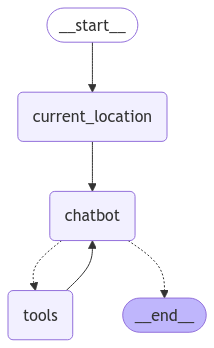

In [138]:
test.display_graph()

In [133]:
test.stream('fun, vegetarian')

================================ Human Message =================================

fun, vegetarian
================================ Human Message =================================

fun, vegetarian
================================== Ai Message ==================================
Tool Calls:
  get_nearby_places (1fd0125d-8a33-42fb-960e-ef5436da15b4)
 Call ID: 1fd0125d-8a33-42fb-960e-ef5436da15b4
  Args:
    query: Fun%20Vegetarian%20Food%20in%20New%20York%20City%20New%20York
no :(
no :(
================================= Tool Message =================================
Name: get_nearby_places

{'Planta Queen': {'address': '15 W 27th St, New York, NY 10001, United States', 'rating': 4.5, 'Price_level': 3, 'google_maps_link': 'https://maps.google.com/?cid=8738392629485778085'}, 'Vegan On The Fly': {'address': '24 W 45th St, New York, NY 10036, United States', 'rating': 4.8, 'Price_level': 2, 'google_maps_link': 'https://maps.google.com/?cid=964311156010106640'}, 'Le Botaniste': {'address': '833

In [44]:
test.get_state('longitude')

-74.006

In [139]:
test.chatbot('find me some vegetarian restaurants in my location')

"Here are some vegetarian restaurants in New York City:\n\n* Vegan On The Fly: 24 W 45th St, New York, NY 10036, United States. Rating: 4.8, Price level: $$. [Google Maps Link](https://maps.google.com/?cid=964311156010106640)\n* Seasoned Vegan Real Quick: 128 2nd Ave, New York, NY 10003, United States. Rating: 4.4, Price level: $$. [Google Maps Link](https://maps.google.com/?cid=4448177612972572696)\n* Urban Vegan Kitchen: 265 W 23rd St, New York, NY 10011, United States. Rating: 4.5, Price level: $$. [Google Maps Link](https://maps.google.com/?cid=5236834666570805349)\n* Planta Queen: 15 W 27th St, New York, NY 10001, United States. Rating: 4.5, Price level: $$$ [Google Maps Link](https://maps.google.com/?cid=8738392629485778085)\n* abcV: 38 E 19th St, New York, NY 10003, United States. Rating: 4.4, Price level: $$$ [Google Maps Link](https://maps.google.com/?cid=2172635308240601344)\n* Le Botaniste: 11 W 42nd St, New York, NY 10036, United States. Rating: 4.6, Price level: $. [Google